In [1]:
%pip install PyPDF2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import PyPDF2

# Open the PDF
with open("ignore/hdfc_statement_2024-2025.pdf", "rb") as file: # Use your bank statement PDF file path
    reader = PyPDF2.PdfReader(file)
    
    # Extract text from all pages
    text = ""
    for page in reader.pages:
        text += page.extract_text() + "\n"

print(text[:1000])  # print first 1000 chars

In [ ]:
import re
import pandas as pd

pattern = re.compile(
    r"(\d{2}/\d{2}/\d{2})\s+(.*?)\s+(\d{2}/\d{2}/\d{2})\s+([\d,]*\.\d{2})?\s*([\d,]*\.\d{2})?\s*([\d,]*\.\d{2})"
)

records = []

for match in pattern.finditer(text):
    date, narration, valuedt, withdraw, deposit, balance = match.groups()
    records.append({
        "Date": date,
        "Narration": narration.strip(),
        "Value Date": valuedt,
        "Withdrawal": float(withdraw.replace(",", "")) if withdraw else 0.0,
        "Deposit": float(deposit.replace(",", "")) if deposit else 0.0,
        "Closing Balance": float(balance.replace(",", "")) if balance else 0.0
    })

df = pd.DataFrame(records)
df.head()

Total Withdrawals: 3426969.2199999997
Total Deposits: 896899.1399999999


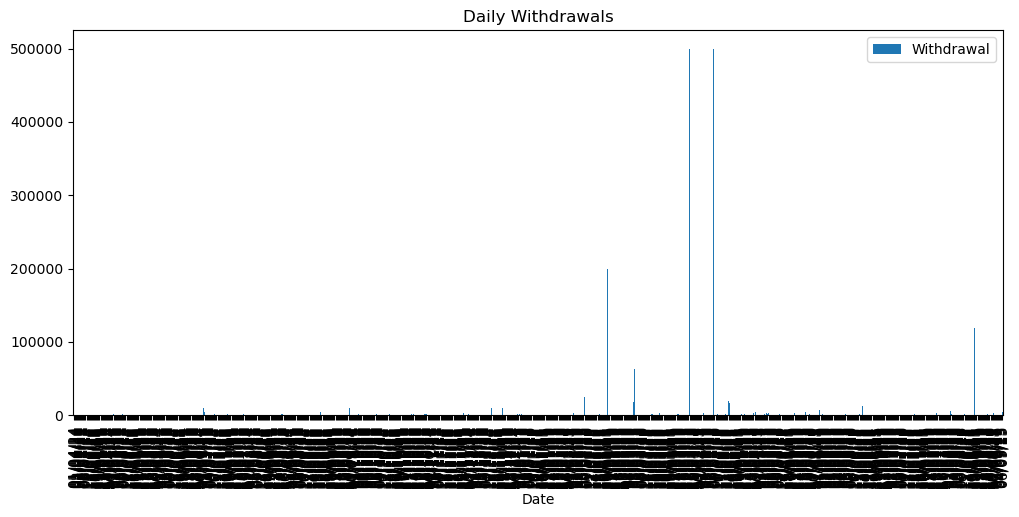

In [4]:
import matplotlib.pyplot as plt

# Total spent
print("Total Withdrawals:", df["Withdrawal"].sum())
print("Total Deposits:", df["Deposit"].sum())

# Plot spending over time
df.plot(x="Date", y="Withdrawal", kind="bar", figsize=(12,5))
plt.title("Daily Withdrawals")
plt.show()

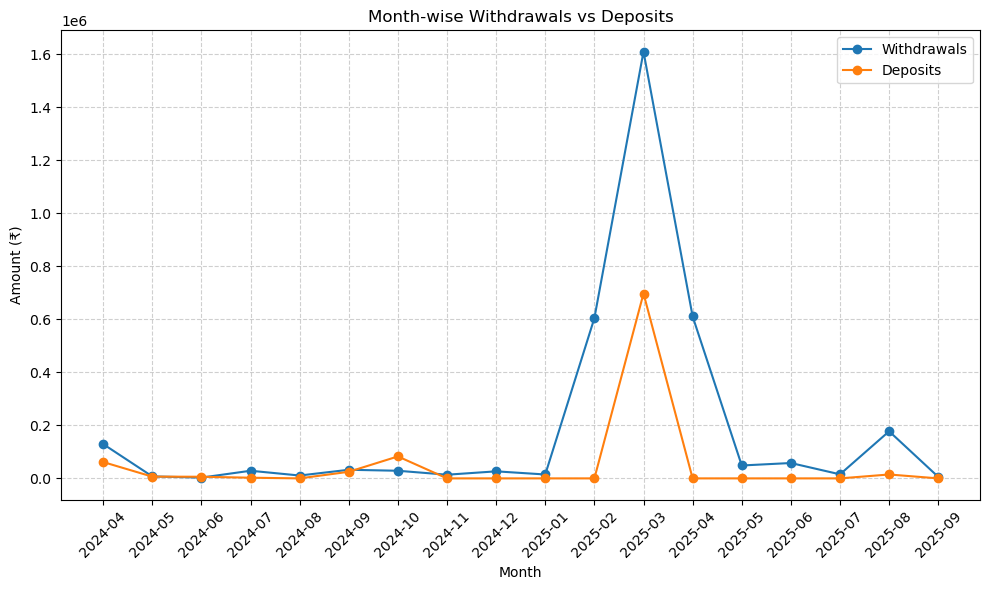

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure Date column is in datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%y")

# Extract Year-Month (e.g., 2025-09)
df["Month"] = df["Date"].dt.to_period("M")

# Group by Month
monthly_summary = df.groupby("Month").agg({
    "Withdrawal": "sum",
    "Deposit": "sum"
}).reset_index()

# Convert Period to string for plotting
monthly_summary["Month"] = monthly_summary["Month"].astype(str)

# Plot
plt.figure(figsize=(10,6))
plt.plot(monthly_summary["Month"], monthly_summary["Withdrawal"], marker="o", label="Withdrawals")
plt.plot(monthly_summary["Month"], monthly_summary["Deposit"], marker="o", label="Deposits")

plt.title("Month-wise Withdrawals vs Deposits")
plt.xlabel("Month")
plt.ylabel("Amount (₹)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Example categories (customize as per your spending habits)
categories = {
    "Food & Groceries": ["ZEPTO", "ZOMATO", "SWIGGY", "MILK", "CANTEEN", "RESTAURANT", "SWEET", "BISCUIT", "CHOCOLATE"],
    "Transport": ["PETROL", "OLA", "UBER", "AUTO", "CNG", "FUEL"],
    "Shopping": ["AMAZON", "FLIPKART", "MARKET", "MALL", "SHOPPING"],
    "Bills & Utilities": ["ELECTRICITY", "WATER", "RECHARGE", "BROADBAND", "JIO", "AIRTEL"],
    "Entertainment": ["NETFLIX", "SPOTIFY", "PRIME", "MOVIE"],
    "Personal Care": ["SALON", "SPA", "BEAUTY", "LAUNDRY"],
    "Others": []  # default fallback
}

In [ ]:
def categorize(narration):
    narration_upper = narration.upper()
    for cat, keywords in categories.items():
        if any(keyword in narration_upper for keyword in keywords):
            return cat
    return "Others"

df["Category"] = df["Narration"].apply(categorize)
df.head(10)

Category
Others               3349506.08
Personal Care          42942.00
Transport              16455.89
Food & Groceries        9860.25
Bills & Utilities       7386.00
Shopping                 670.00
Entertainment            149.00
Name: Withdrawal, dtype: float64


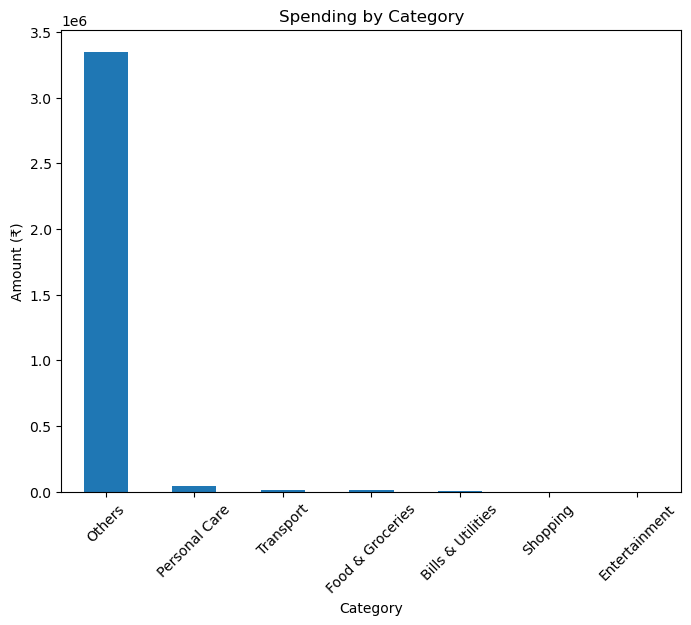

In [8]:
# Total spent per category
category_summary = df.groupby("Category")["Withdrawal"].sum().sort_values(ascending=False)

print(category_summary)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
category_summary.plot(kind="bar")
plt.title("Spending by Category")
plt.ylabel("Amount (₹)")
plt.xticks(rotation=45)
plt.show()

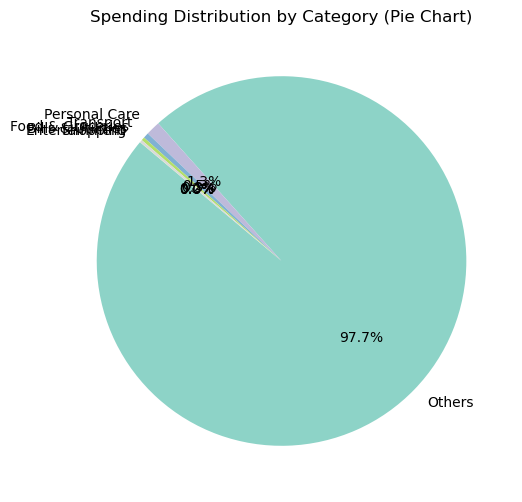

In [9]:
plt.figure(figsize=(8,6))
category_summary.plot(kind="pie", autopct='%1.1f%%', startangle=140, colormap="Set3")
plt.ylabel("")  # hide y-label
plt.title("Spending Distribution by Category (Pie Chart)")
plt.show()

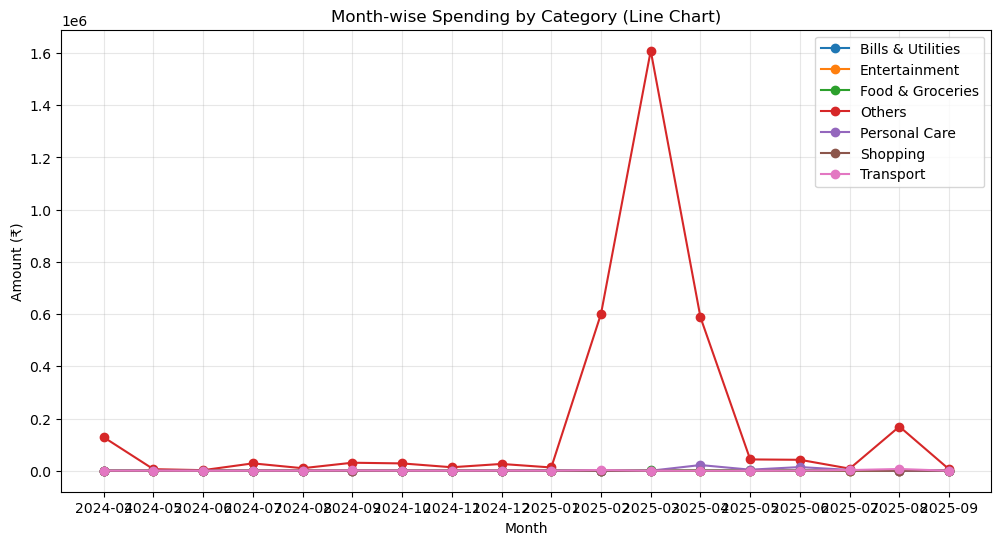

In [10]:
# Group by Month + Category
df["Month"] = df["Date"].dt.to_period("M").astype(str)
monthly_category = df.groupby(["Month", "Category"])["Withdrawal"].sum().unstack().fillna(0)

plt.figure(figsize=(12,6))
for col in monthly_category.columns:
    plt.plot(monthly_category.index, monthly_category[col], marker="o", label=col)

plt.title("Month-wise Spending by Category (Line Chart)")
plt.xlabel("Month")
plt.ylabel("Amount (₹)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

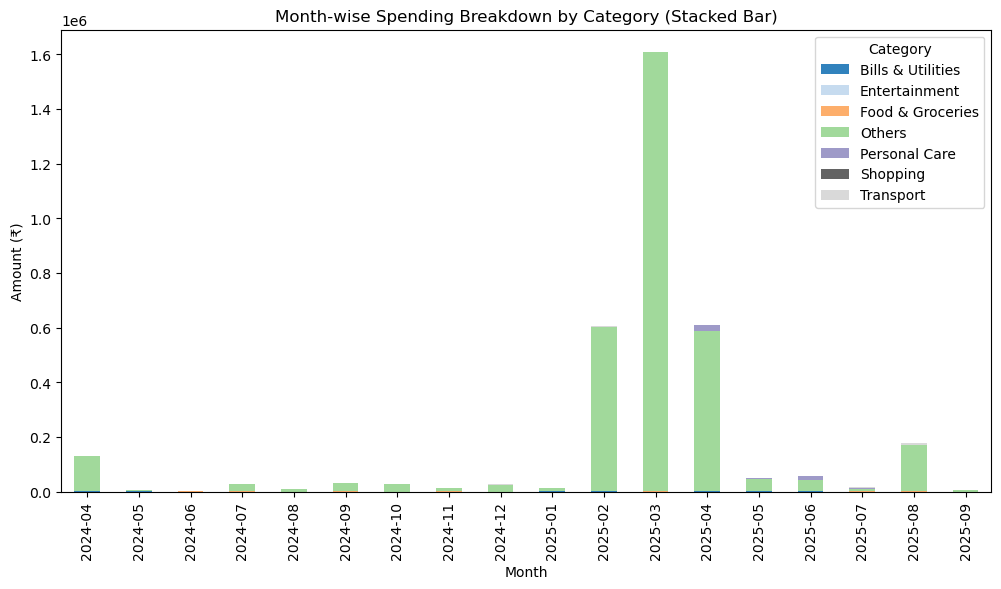

In [11]:
monthly_category.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20c")
plt.title("Month-wise Spending Breakdown by Category (Stacked Bar)")
plt.xlabel("Month")
plt.ylabel("Amount (₹)")
plt.legend(title="Category")
plt.show()

In [ ]:
others_df = df[df["Category"] == "Others"]
print("Expenses categorized as 'Others':")
for idx, row in others_df.iterrows():
    print(f"{idx}: {row['Date']} | {row['Withdrawal']} | {row['Narration']}")

# Optionally, let user re-categorize
for idx, row in others_df.iterrows():
    print(f"\nIndex: {idx}\nDate: {row['Date']}\nAmount: {row['Withdrawal']}\nNarration: {row['Narration']}")
    new_cat = input("Enter new category (or press Enter to keep as 'Others'): ").strip()
    if new_cat:
        df.at[idx, "Category"] = new_cat

print("Updated categories for 'Others':")
print(df.loc[others_df.index][["Date", "Withdrawal", "Narration", "Category"]])

In [ ]:
# Group 'Others' by narration prefix (first part before first space or '-')
import re

others_df = df[df["Category"] == "Others"].copy()

def get_prefix(narration):
    # Extract up to first '-' or space (customize as needed)
    match = re.match(r"([A-Z0-9& ]+?)[- ]", narration.upper())
    return match.group(1).strip() if match else narration[:20]

others_df["Prefix"] = others_df["Narration"].apply(get_prefix)

for prefix, group in others_df.groupby("Prefix"):
    print(f"\nGroup: {prefix}")
    print(group[["Date", "Withdrawal", "Narration"]])
    new_cat = input(f"Enter category for group '{prefix}' (or press Enter to skip): ").strip()
    if new_cat:
        df.loc[group.index, "Category"] = new_cat

print("Updated categories for grouped 'Others':")
print(df.loc[others_df.index][["Date", "Withdrawal", "Narration", "Category"]])